In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import time

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import skimage.io
import cv2
import openslide
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json, load_model



In [3]:
test_datagen = ImageDataGenerator(rescale = 1/255)

In [4]:
#os.listdir('../input/panda-model-1')

In [5]:
#folders:
base_path = "../input"

#for debug:
from_fold = '../input/prostate-cancer-grade-assessment/train_images' 
test_labels = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv')

#for submission
#from_fold = '../input/prostate-cancer-grade-assessment/test_images' 
#test_labels = pd.read_csv('../input/prostate-cancer-grade-assessment/test.csv')


In [6]:
labels_perm = test_labels.sample(frac = 1, random_state = 137)
test_labels = labels_perm[9400:]

In [7]:
model_path ='panda6model' #this is a name of the folder, where we upload the model
model_name = 'model_panda_check.11.h5'


In [8]:
#all constatnts
dim_y = 256
dim_x = 256

In [9]:
#proc_func input parameters:
arg_to_proc_func = {
                'sz':64,
                'N':16} 

In [10]:
#load model:
new_model = load_model(os.path.join(base_path, model_path, model_name))

In [27]:
def prepare_test_data(proc_func):

    def wrapper(df_name = test_labels[:20],
                       zoom = 2,
                       **kw):

        """
        This is based on 'eliminate_white_direct'
        """
        test_data = []
        images_names = []
        
        for i,row in enumerate(df_name.iterrows()):        
            image_id = row[1]['image_id']
            provider = row[1]['data_provider'] 
            images_names.append(image_id)
            test_file = os.path.join(from_fold, image_id + '.tiff')
            biopsy = openslide.OpenSlide(test_file)            
            yyy = biopsy.level_dimensions[zoom]
            biopsy = np.array(biopsy.read_region((0,0), zoom, yyy).convert('RGB'))
            #biopsy = cv2.cvtColor(biopsy, cv2.COLOR_BGR2RGB)
            #print(sum(sum(biopsy)))

            #central block:
            try:
                data_new = proc_func(biopsy, provider, **kw)
            except:
                data_new = biopsy
            #end central block
            
            biopsy = data_new #cv2.resize(data_new, (dim_y, dim_x))
            
            try:
                del data_new
            except:
                pass
           
            test_data.append(biopsy)
             
            del biopsy
    
        return np.array(images_names), np.array(test_data) #wrapper end
    
    return wrapper #decorator end

In [28]:
@prepare_test_data
def img_func(img, provider, **kw):        
    sz=kw.get('sz') if kw.get('sz') else 32    
    N = kw.get('N') if kw.get('N') else 16
    final_dim = kw.get('final_dim') if kw.get('final_dim') else N**0.5 
    result = []
    shape = img.shape
    #if shape[0]<shape[1]: 
    #    img = np.rot90(img)
    #    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=255)
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    if len(img) < N:
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    img = img[idxs]
    a, b, c, d = img.shape
    data_new = (img.reshape(int(final_dim), int(final_dim),\
                                                    b, c, d).swapaxes(1,2).reshape(b*int(final_dim),\
                                                    c*int(final_dim), d))
    data_new = cv2.bitwise_not(data_new)

    return data_new

#substitute for appropriate prcocessing function

In [13]:
def make_final_labels(from_model_preds):
    return from_model_preds.argmax(axis=-1)

In [14]:
def make_submission_df(id_array, test_labels):
    d2 = {'image_id': id_array, 'isup_grade': test_labels}
    new_sample = pd.DataFrame(data=d2)
    return new_sample

In [29]:
if os.path.exists(from_fold):
    #list of test files:
    test_files = os.listdir(from_fold)
    
    #prepare input data for the model:
    test_files_id_array, test_file_data_array = img_func(**arg_to_proc_func)
    testgen = test_datagen.flow(
                            x=test_file_data_array,
                            y=None, 
                            batch_size=1,
                            shuffle = False,
                            )
    #predict with the model:
    pred_all = new_model.predict_generator(testgen, steps = len(test_files_id_array))
    #make final predictions:
    final_test_labels = make_final_labels(pred_all)
    
    #make submission:
    submission = make_submission_df(test_files_id_array, final_test_labels)
    submission['isup_grade'] = submission['isup_grade'].astype(int)
    submission.to_csv('submission.csv', index=False)

else: #test data are covered
    sub = pd.read_csv("/kaggle/input/prostate-cancer-grade-assessment/sample_submission.csv")
    sub.to_csv('submission.csv', index=False)
    print('no submission data')

In [30]:
submission

,image_id,isup_grade
0,d3a5775345ddc4976944ff1941709ef0,0
1,e20c73041c5c5ac83c20a7c669f46e9a,0
2,8f8d20fc6e9b6aa3b145e359e104eac4,3
3,6ac2095c7968fa30ab6c5dc7d1ed5121,0
4,389758c9e3aad00e774d581150f372db,3


In [19]:
sum(sum(test_file_data_array[1]))

array([ 45,   6, 247], dtype=uint8)

In [23]:
tt = cv2.cvtColor(test_file_data_array[1], cv2.COLOR_BGR2RGB)

In [26]:
sum(sum(tt))

array([247,   6,  45], dtype=uint8)

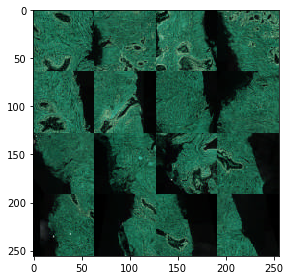

In [24]:
skimage.io.imshow(tt)